In [37]:
import pandas as pd
import librosa
import os
import numpy as np
import re
from pydub import AudioSegment, effects
import noisereduce as nr
import logging

logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')


In [38]:
df = pd.read_csv('data/songs_wav.csv')

In [39]:
def sanitize_filename(filename):
    """
    Removes or replaces invalid characters from a filename or folder name.
    
    Args:
        filename (str): The original filename or folder name.
        
    Returns:
        str: The sanitized filename or folder name.
    """
    return re.sub(r'[<>:"/\\|?*]', '', filename)

def normalized_yt_title(title):
    """
    Normalizes a YouTube title by converting it to lowercase, replacing spaces with underscores,
    and removing non-alphanumeric characters except underscores.
    
    Args:
        title (str): The original title of the YouTube video.
        
    Returns:
        str: The normalized title.
    """
    text = title.lower()
    text = text.replace(' ', '_')
    text = re.sub(r'[^a-z0-9_]', '', text)
    text = re.sub(r'_{2,}', '_', text)
    
    return text

def remove_silence(audio, threshold=20):
    """
    Removes silent sections from an audio signal based on a decibel threshold.
    
    Args:
        audio (ndarray): The audio signal as a numpy array.
        threshold (int): The decibel threshold to trim silence. Defaults to 20.
        
    Returns:
        ndarray: The trimmed audio signal.
    """
    return librosa.effects.trim(audio, top_db=threshold)[0]

def normalize_audio(audio):
    """
    Normalizes the audio signal to a standard volume level.
    
    Args:
        audio (AudioSegment): The audio segment to normalize.
        
    Returns:
        AudioSegment: The normalized audio segment.
    """
    return effects.normalize(audio)

def noise_reduction(audio, noise_profile):
    """
    Reduces noise from an audio signal using a noise profile.
    
    Args:
        audio (ndarray): The audio signal as a numpy array.
        noise_profile (ndarray): The noise profile as a numpy array.
        
    Returns:
        ndarray: The noise-reduced audio signal.
    """
    return nr.reduce_noise(audio_clip=audio, noise_clip=noise_profile)

split_result = []

def split_songs_to_segments(df, output_base_folder='datasets/30s_segments'):
    """
    Splits songs into 30-second segments and saves them as individual files.
    
    Args:
        df (DataFrame): A pandas DataFrame containing song metadata with 'wav_path' and 'nama_lagu' columns.
        output_base_folder (str): The base folder to save the segments. Defaults to 'datasets/30s_segments'.
        
    Returns:
        None
    """
    for index, row in df.iterrows():
        wav_path = row['wav_path']
        nama_lagu = row['nama_lagu']
        
        os.makedirs(f"{output_base_folder}/{normalized_yt_title(nama_lagu)}", exist_ok=True)
        
        audio = AudioSegment.from_wav(wav_path)
        audio = audio.set_channels(1)
        
        audio = normalize_audio(audio)
        
        total_duration = len(audio) / 1000
        segment_duration = 30
        num_segments = int(total_duration // segment_duration)
        
        for i in range(num_segments):
            start_time = i * segment_duration * 1000 
            end_time = (i + 1) * segment_duration * 1000
            segment = audio[start_time:end_time]
            
            segment_file = f"{output_base_folder}/{normalized_yt_title(nama_lagu)}/segment_{index}_{i}.wav"
            segment.export(segment_file, format="wav")
            
            split_result.append({
                'title': nama_lagu,
                '30s_path': segment_file
            })
        print(f"Saved {num_segments} segments for {nama_lagu} at: {output_base_folder}/{normalized_yt_title(nama_lagu)}")

In [40]:
split_songs_to_segments(df)

Saved 7 segments for Kicir-kicir at: datasets/30s_segments/kicirkicir
Saved 7 segments for Kicir-kicir at: datasets/30s_segments/kicirkicir
Saved 7 segments for Kicir-kicir at: datasets/30s_segments/kicirkicir
Saved 4 segments for Kicir-kicir at: datasets/30s_segments/kicirkicir
Saved 7 segments for Kicir-kicir at: datasets/30s_segments/kicirkicir
Saved 7 segments for Kicir-kicir at: datasets/30s_segments/kicirkicir
Saved 7 segments for Kicir-kicir at: datasets/30s_segments/kicirkicir
Saved 7 segments for Kicir-kicir at: datasets/30s_segments/kicirkicir
Saved 12 segments for Kicir-kicir at: datasets/30s_segments/kicirkicir
Saved 10 segments for Kicir-kicir at: datasets/30s_segments/kicirkicir
Saved 7 segments for Kicir-kicir at: datasets/30s_segments/kicirkicir
Saved 5 segments for Kicir-kicir at: datasets/30s_segments/kicirkicir
Saved 3 segments for Kicir-kicir at: datasets/30s_segments/kicirkicir
Saved 7 segments for Kicir-kicir at: datasets/30s_segments/kicirkicir
Saved 7 segments f

In [41]:
# save split result to csv
split_result_df = pd.DataFrame(split_result)
split_result_df.to_csv('data/30s_segments.csv', index=False)

In [42]:
df_res = pd.read_csv('data/30s_segments.csv')
df_res.head()

,title,30s_path
0,Kicir-kicir,datasets/30s_segments/kicirkicir/segment_0_0.wav
1,Kicir-kicir,datasets/30s_segments/kicirkicir/segment_0_1.wav
2,Kicir-kicir,datasets/30s_segments/kicirkicir/segment_0_2.wav
3,Kicir-kicir,datasets/30s_segments/kicirkicir/segment_0_3.wav
4,Kicir-kicir,datasets/30s_segments/kicirkicir/segment_0_4.wav


### Data Augmentation

In [43]:
def noise(data):
    """
    Adds random noise to an audio signal to augment data.

    Args:
        data (ndarray): The audio signal as a numpy array.

    Returns:
        ndarray: The audio signal with added noise.
    """
    noise_amp = 0.05 * np.random.uniform() * np.amax(data)
    data = data.astype('float64') + noise_amp * np.random.normal(size=data.shape[0])
    return data

def stretch(data, rate=1.0):
    """
    Stretches or compresses the audio by a given rate.

    Args:
        data (ndarray): The audio signal as a numpy array.
        rate (float): The rate to stretch the audio. A value > 1 speeds it up, < 1 slows it down.

    Returns:
        ndarray: The time-stretched audio signal.
    """
    data = librosa.effects.time_stretch(data, rate)
    return data

def pitch_shift(data, sample_rate):
    """
    Shifts the pitch of an audio signal.

    Args:
        data (ndarray): The audio signal as a numpy array.
        sample_rate (int): The sampling rate of the audio signal.

    Returns:
        ndarray: The pitch-shifted audio signal.
    """
    bins_per_octave = 12
    pitch_pm = 2
    pitch_change =  pitch_pm * 2*(np.random.uniform())
    data = librosa.effects.pitch_shift(data.astype('float64'), 
                                       sample_rate, n_steps=pitch_change, 
                                       bins_per_octave=bins_per_octave)
    return data

def speedNpitch(data):
    """
    Adjusts both the speed and pitch of an audio signal.

    Args:
        data (ndarray): The audio signal as a numpy array.

    Returns:
        ndarray: The audio signal with modified speed and pitch.
    """
    length_change = np.random.uniform(low=0.8, high = 1)
    speed_fac = 1.2  / length_change
    tmp = np.interp(np.arange(0,len(data),speed_fac),np.arange(0,len(data)),data)
    minlen = min(data.shape[0], tmp.shape[0])
    data *= 0
    data[0:minlen] = tmp[0:minlen]
    return data

def pad_or_truncate(data, length):
    """
    Pads or truncates an audio signal to the specified length.

    Args:
        data (ndarray): The audio signal as a numpy array.
        length (int): The desired length of the audio signal.

    Returns:
        ndarray: The audio signal padded or truncated to the specified length.
    """
    if len(data) > length:
        return data[:length]
    elif len(data) < length:
        return np.pad(data, (0, length - len(data)), 'constant')
    
    return data

### Feature Extraction

In [44]:
# extract the feature using mfcc
extract_res = []
def mfcc_features(data):
    """
    Extract MFCC (Mel-frequency cepstral coefficients) features from the dataset.

    Args:
        data (pandas.DataFrame): A DataFrame containing paths to audio files and their titles.

    Returns:
        list: A list of dictionaries with titles, paths, and extracted features.
    """
    try:
        for index, row in data.iterrows():
            audio, sample_rate = librosa.load(row['30s_path'])
            mfcc_def = np.mean(librosa.feature.mfcc(y=audio, sr=sample_rate, n_mfcc=40).T, axis=0)

            augmentations = [
                lambda x: noise(x),
                lambda x: speedNpitch(x)
            ]

            extract_res.append({
                'title': row['title'],
                '30s_path': row['30s_path'],
                'features': mfcc_def
            })

            for aug in augmentations:
                augmented_data = aug(audio)
                mfccs = np.mean(librosa.feature.mfcc(y=augmented_data, sr=sample_rate, n_mfcc=40).T, axis=0)
                extract_res.append({
                    'title': row['title'],
                    '30s_path': row['30s_path'],
                    'features': mfccs
                })
        return extract_res
    except Exception as e:
        logging.error(f"Error {e} encountered while parsing file: {data['30s_path']}")
        return None 

def chroma_features(file_path):
    """
    Extract chroma features from an audio file.

    Args:
        file_path (str): Path to the audio file.

    Returns:
        numpy.ndarray: Processed chroma features.
    """
    try:
        audio, sample_rate = librosa.load(file_path) 
        chroma = librosa.feature.chroma_stft(y=audio, sr=sample_rate)
        chroma_processed = np.mean(chroma.T,axis=0)
    except Exception as e:
        logging.error(f"Error encountered while parsing file: {file_path}")
        return None 
     
    return chroma_processed

def mel_features(file_path):
    """
    Extract Mel-spectrogram features from an audio file.

    Args:
        file_path (str): Path to the audio file.

    Returns:
        numpy.ndarray: Processed Mel-spectrogram features.
    """
    try:
        audio, sample_rate = librosa.load(file_path) 
        mel = librosa.feature.melspectrogram(y=audio, sr=sample_rate)
        mel_processed = np.mean(mel.T,axis=0)
    except Exception as e:
        logging.error(f"Error encountered while parsing file: {file_path}")
        return None 
     
    return mel_processed

def combined_features(file_path):
    """
    Combine MFCC and chroma features from an audio file.

    Args:
        file_path (str): Path to the audio file.

    Returns:
        numpy.ndarray: Concatenated features of MFCC and chroma.
    """
    mfcc = mfcc_features(file_path)
    chroma = chroma_features(file_path)
    # mel = mel_features(file_path)
    
    return np.concatenate((mfcc, chroma))

In [45]:
features = mfcc_features(df_res)
df_features = pd.DataFrame(features)

In [46]:
df_features.to_csv('data/30s_segments_features.csv', index=False)
df_features.head()

,title,30s_path,features
0,Kicir-kicir,datasets/30s_segments/kicirkicir/segment_0_0.wav,"[-108.271675, 104.1323, -12.744977, 28.166916,..."
1,Kicir-kicir,datasets/30s_segments/kicirkicir/segment_0_0.wav,"[-26.96562955822612, 47.87981042077912, 8.9385..."
2,Kicir-kicir,datasets/30s_segments/kicirkicir/segment_0_0.wav,"[-185.57063, 65.69897, -7.4303737, 17.239698, ..."
3,Kicir-kicir,datasets/30s_segments/kicirkicir/segment_0_1.wav,"[-54.211422, 107.55626, -24.28167, 38.033943, ..."
4,Kicir-kicir,datasets/30s_segments/kicirkicir/segment_0_1.wav,"[-28.08828370986219, 77.93120331804678, -2.555..."


In [47]:
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

def print_score(clf, X_train, y_train, X_test, y_test, train=True):    
    if train:
        pred = clf.predict(X_train)
        clf_report = classification_report(y_train, pred, zero_division=1)
        print("Train Result:\n================================================")
        print(f"Accuracy Score: {accuracy_score(y_train, pred) * 100:.2f}%")
        print(f"F1 Score: {f1_score(y_train, pred, average='weighted', zero_division=1) * 100:.2f}%")
        print(f"Precision Score: {precision_score(y_train, pred, average='weighted', zero_division=1) * 100:.2f}%")
        print(f"Recall Score: {recall_score(y_train, pred, average='weighted', zero_division=1) * 100:.2f}%")
        print("_______________________________________________")
        print(f"CLASSIFICATION REPORT:\n{clf_report}")
        print("_______________________________________________")
        print(f"Confusion Matrix: \n {confusion_matrix(y_train, pred)}\n")
        
    elif train==False:
        pred = clf.predict(X_test)
        clf_report = classification_report(y_test, pred, zero_division=1)
        print("Test Result:\n================================================")        
        print(f"Accuracy Score: {accuracy_score(y_test, pred) * 100:.2f}%")
        print(f"F1 Score: {f1_score(y_test, pred, average='weighted', zero_division=1) * 100:.2f}%")
        print(f"Precision Score: {precision_score(y_test, pred, average='weighted', zero_division=1) * 100:.2f}%")
        print(f"Recall Score: {recall_score(y_test, pred, average='weighted', zero_division=1) * 100:.2f}%")
        print("_______________________________________________")
        print(f"CLASSIFICATION REPORT:\n{clf_report}")
        print("_______________________________________________")
        print(f"Confusion Matrix: \n {confusion_matrix(y_test, pred)}\n")


In [48]:
from sklearn.model_selection import train_test_split

# Prepare the data
X = []
y = []

for index, row in df_features.iterrows():
    label = row['title']
    features = row['features']
    
    X.append(features)
    y.append(label)
    
X = np.array(X)
y = np.array(y)

In [49]:
print(f"X shape: {X.shape}, y shape: {y.shape}")

X shape: (4464, 40), y shape: (4464,)


### RANDOM FOREST

In [50]:
from sklearn.ensemble import RandomForestClassifier
# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train a model
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [51]:
# Evaluate the model
print_score(model, X_train, y_train, X_test, y_test, train=True)

Train Result:
Accuracy Score: 100.00%
F1 Score: 100.00%
Precision Score: 100.00%
Recall Score: 100.00%
_______________________________________________
CLASSIFICATION REPORT:
                    precision    recall  f1-score   support

Ampar-ampar Pisang       1.00      1.00      1.00       468
             Apuse       1.00      1.00      1.00       595
     Bengawan Solo       1.00      1.00      1.00      1018
       Kicir-kicir       1.00      1.00      1.00       830
 Yamko Rambe Yamko       1.00      1.00      1.00       660

          accuracy                           1.00      3571
         macro avg       1.00      1.00      1.00      3571
      weighted avg       1.00      1.00      1.00      3571

_______________________________________________
Confusion Matrix: 
 [[ 468    0    0    0    0]
 [   0  595    0    0    0]
 [   0    0 1018    0    0]
 [   0    0    0  830    0]
 [   0    0    0    0  660]]



In [52]:
print_score(model, X_train, y_train, X_test, y_test, train=False)

Test Result:
Accuracy Score: 91.94%
F1 Score: 91.95%
Precision Score: 92.33%
Recall Score: 91.94%
_______________________________________________
CLASSIFICATION REPORT:
                    precision    recall  f1-score   support

Ampar-ampar Pisang       0.99      0.88      0.93       138
             Apuse       0.99      0.94      0.97       143
     Bengawan Solo       0.86      0.98      0.91       245
       Kicir-kicir       0.92      0.92      0.92       205
 Yamko Rambe Yamko       0.91      0.85      0.88       162

          accuracy                           0.92       893
         macro avg       0.93      0.91      0.92       893
      weighted avg       0.92      0.92      0.92       893

_______________________________________________
Confusion Matrix: 
 [[121   0   7   5   5]
 [  0 135   3   2   3]
 [  0   0 239   5   1]
 [  1   1  10 188   5]
 [  0   0  19   5 138]]



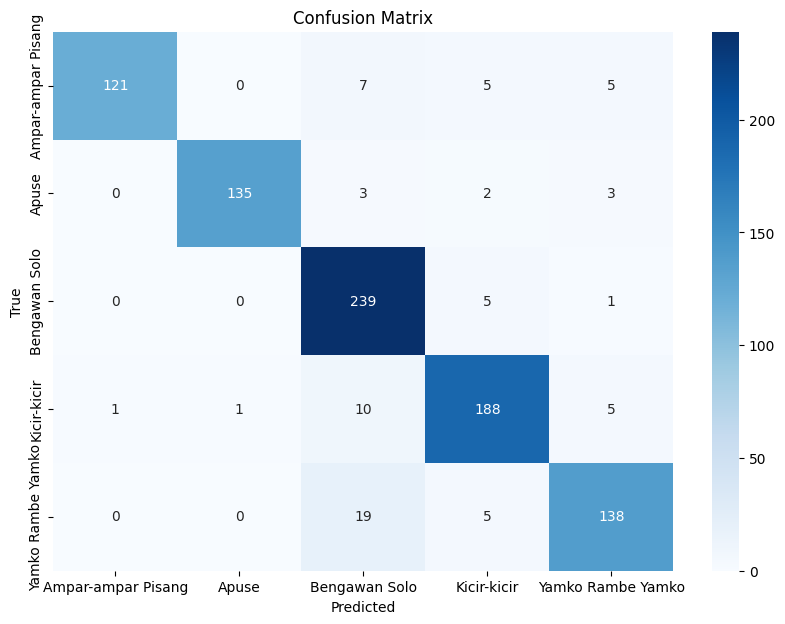

In [53]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

import matplotlib.pyplot as plt

y_pred = model.predict(X_test)

# Generate the confusion matrix
cm = confusion_matrix(y_test, y_pred, labels=model.classes_)

# Plot the confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=model.classes_, yticklabels=model.classes_)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

### SVM - Supervised ML

In [54]:
from sklearn.svm import SVC

# Train an SVM model
svm_model = SVC(kernel='linear', random_state=42, C=10)
svm_model.fit(X_train, y_train)


SVC(C=10, kernel='linear', random_state=42)

In [55]:
# Evaluate the SVM model
print_score(svm_model, X_train, y_train, X_test, y_test, train=True)

Train Result:
Accuracy Score: 68.50%
F1 Score: 68.26%
Precision Score: 68.34%
Recall Score: 68.50%
_______________________________________________
CLASSIFICATION REPORT:
                    precision    recall  f1-score   support

Ampar-ampar Pisang       0.60      0.52      0.56       468
             Apuse       0.76      0.71      0.73       595
     Bengawan Solo       0.69      0.80      0.74      1018
       Kicir-kicir       0.71      0.69      0.70       830
 Yamko Rambe Yamko       0.64      0.60      0.62       660

          accuracy                           0.68      3571
         macro avg       0.68      0.66      0.67      3571
      weighted avg       0.68      0.68      0.68      3571

_______________________________________________
Confusion Matrix: 
 [[244  27  74  53  70]
 [ 37 420  93  33  12]
 [ 48  37 810  66  57]
 [ 31  41  95 576  87]
 [ 49  31  95  89 396]]



In [56]:

print_score(svm_model, X_train, y_train, X_test, y_test, train=False)

Test Result:
Accuracy Score: 66.97%
F1 Score: 66.63%
Precision Score: 66.85%
Recall Score: 66.97%
_______________________________________________
CLASSIFICATION REPORT:
                    precision    recall  f1-score   support

Ampar-ampar Pisang       0.63      0.54      0.58       138
             Apuse       0.71      0.67      0.69       143
     Bengawan Solo       0.68      0.80      0.74       245
       Kicir-kicir       0.66      0.68      0.67       205
 Yamko Rambe Yamko       0.66      0.56      0.61       162

          accuracy                           0.67       893
         macro avg       0.67      0.65      0.66       893
      weighted avg       0.67      0.67      0.67       893

_______________________________________________
Confusion Matrix: 
 [[ 75   8  21  14  20]
 [ 13  96  19  12   3]
 [ 11  11 197  18   8]
 [  9  14  27 139  16]
 [ 11   6  26  28  91]]



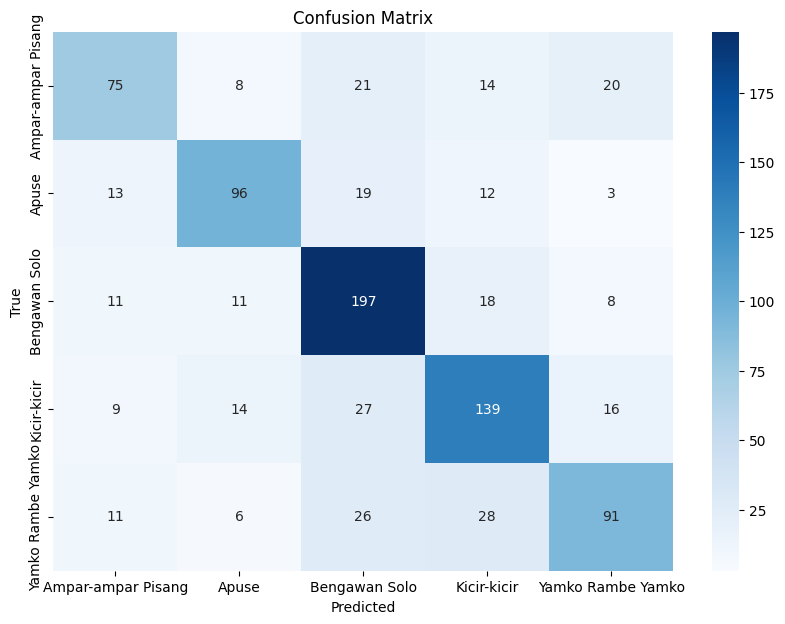

In [57]:
# confusion matrix
y_pred = svm_model.predict(X_test)

# Generate the confusion matrix
cm = confusion_matrix(y_test, y_pred, labels=svm_model.classes_)
# Plot the confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=svm_model.classes_, yticklabels=svm_model.classes_)

plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

### Decision Tree's

In [58]:
from sklearn.tree import DecisionTreeClassifier

# Train a Decision Tree model
dt_model = DecisionTreeClassifier(random_state=42)
dt_model.fit(X_train, y_train)

DecisionTreeClassifier(random_state=42)

In [59]:
# Evaluate the Decision Tree model on the training data
print_score(dt_model, X_train, y_train, X_test, y_test, train=True)

Train Result:
Accuracy Score: 100.00%
F1 Score: 100.00%
Precision Score: 100.00%
Recall Score: 100.00%
_______________________________________________
CLASSIFICATION REPORT:
                    precision    recall  f1-score   support

Ampar-ampar Pisang       1.00      1.00      1.00       468
             Apuse       1.00      1.00      1.00       595
     Bengawan Solo       1.00      1.00      1.00      1018
       Kicir-kicir       1.00      1.00      1.00       830
 Yamko Rambe Yamko       1.00      1.00      1.00       660

          accuracy                           1.00      3571
         macro avg       1.00      1.00      1.00      3571
      weighted avg       1.00      1.00      1.00      3571

_______________________________________________
Confusion Matrix: 
 [[ 468    0    0    0    0]
 [   0  595    0    0    0]
 [   0    0 1018    0    0]
 [   0    0    0  830    0]
 [   0    0    0    0  660]]



In [60]:
# Evaluate the Decision Tree model on the test data
print_score(dt_model, X_train, y_train, X_test, y_test, train=False)

Test Result:
Accuracy Score: 76.04%
F1 Score: 76.05%
Precision Score: 76.11%
Recall Score: 76.04%
_______________________________________________
CLASSIFICATION REPORT:
                    precision    recall  f1-score   support

Ampar-ampar Pisang       0.70      0.73      0.72       138
             Apuse       0.80      0.80      0.80       143
     Bengawan Solo       0.77      0.74      0.76       245
       Kicir-kicir       0.80      0.80      0.80       205
 Yamko Rambe Yamko       0.71      0.73      0.72       162

          accuracy                           0.76       893
         macro avg       0.76      0.76      0.76       893
      weighted avg       0.76      0.76      0.76       893

_______________________________________________
Confusion Matrix: 
 [[101   5  11  11  10]
 [  5 115   8   7   8]
 [ 16  13 181  14  21]
 [  9   5  18 164   9]
 [ 13   5  16  10 118]]



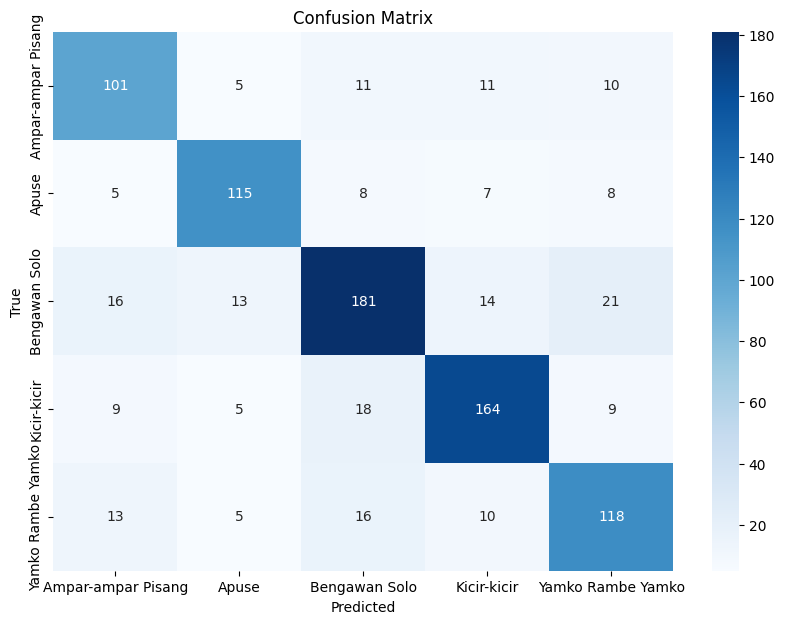

In [61]:
# confusion matrix
y_pred = dt_model.predict(X_test)

# Generate the confusion matrix
cm = confusion_matrix(y_test, y_pred, labels=dt_model.classes_)
# Plot the confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=dt_model.classes_, yticklabels=dt_model.classes_)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# KNN

In [62]:
# knn
from sklearn.neighbors import KNeighborsClassifier

# Train a KNN model
knn_model = KNeighborsClassifier(n_neighbors=5)

knn_model.fit(X_train, y_train)

KNeighborsClassifier()

In [63]:
print_score(knn_model, X_train, y_train, X_test, y_test, train=True)

Train Result:
Accuracy Score: 88.88%
F1 Score: 88.86%
Precision Score: 88.90%
Recall Score: 88.88%
_______________________________________________
CLASSIFICATION REPORT:
                    precision    recall  f1-score   support

Ampar-ampar Pisang       0.85      0.85      0.85       468
             Apuse       0.87      0.93      0.90       595
     Bengawan Solo       0.91      0.92      0.92      1018
       Kicir-kicir       0.92      0.89      0.90       830
 Yamko Rambe Yamko       0.87      0.82      0.84       660

          accuracy                           0.89      3571
         macro avg       0.88      0.88      0.88      3571
      weighted avg       0.89      0.89      0.89      3571

_______________________________________________
Confusion Matrix: 
 [[399  19   8  14  28]
 [ 10 553  10   8  14]
 [ 19  22 941  14  22]
 [ 20  22  30 738  20]
 [ 22  22  41  32 543]]



In [64]:
print_score(knn_model, X_train, y_train, X_test, y_test, train=False)

Test Result:
Accuracy Score: 78.95%
F1 Score: 78.88%
Precision Score: 78.92%
Recall Score: 78.95%
_______________________________________________
CLASSIFICATION REPORT:
                    precision    recall  f1-score   support

Ampar-ampar Pisang       0.70      0.72      0.71       138
             Apuse       0.79      0.83      0.81       143
     Bengawan Solo       0.82      0.85      0.84       245
       Kicir-kicir       0.83      0.81      0.82       205
 Yamko Rambe Yamko       0.76      0.69      0.72       162

          accuracy                           0.79       893
         macro avg       0.78      0.78      0.78       893
      weighted avg       0.79      0.79      0.79       893

_______________________________________________
Confusion Matrix: 
 [[ 99   6   9  10  14]
 [  6 119   4   8   6]
 [ 12  12 209   3   9]
 [ 13   7  11 167   7]
 [ 12   6  21  12 111]]



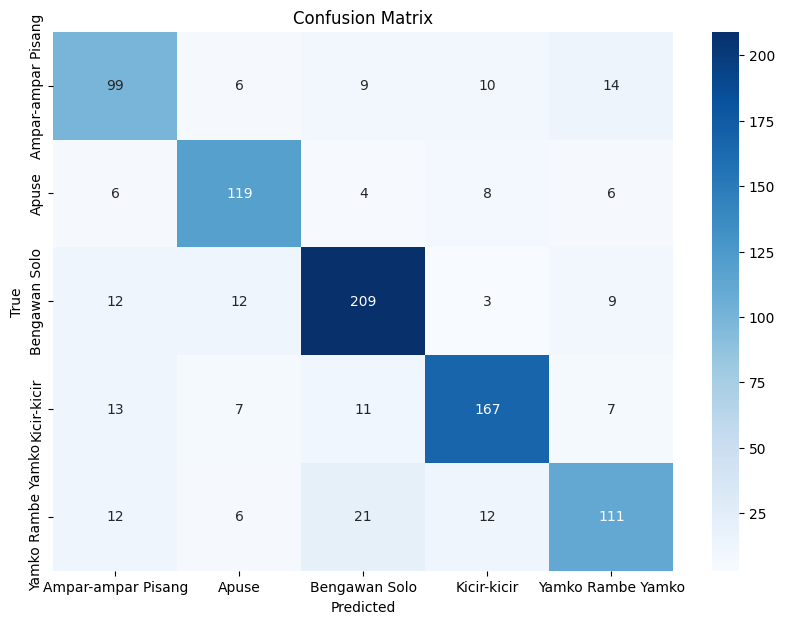

In [65]:
# confusion matrix
y_pred = knn_model.predict(X_test)

# Generate the confusion matrix
cm = confusion_matrix(y_test, y_pred, labels=knn_model.classes_)
# Plot the confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=knn_model.classes_, yticklabels=knn_model.classes_)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [66]:
# save all models
import pickle

# Save the models
with open('models/random_forest_model.pkl', 'wb') as file:
    pickle.dump(model, file)
    
with open('models/svm_model.pkl', 'wb') as file:
    pickle.dump(svm_model, file)
    
with open('models/decision_tree_model.pkl', 'wb') as file:
    pickle.dump(dt_model, file)
    
with open('models/knn_model.pkl', 'wb') as file:
    pickle.dump(knn_model, file)

In [ ]:
# test with external data
def predict_song(model, file_path):
    """
    Predicts the genre of a song using a trained model.

    Args:
        model: The trained model to use for prediction.
        file_path (str): The path to the audio file to predict.

    Returns:
        str: The predicted genre of the song.
    """
    features = mfcc_features(file_path)
    prediction = model.predict(features.reshape(1, -1))
    return prediction[0]

In [ ]:
svm_pred = predict_song(svm_model, 'data/30s_segments/alan_walker/segment_0_0.wav')